# 🧾 Cyber Threat Data Cleaning & Exploration
This notebook loads a cyber threat Excel dataset, cleans it, and visualizes attack trends.

In [5]:
import pandas as pd
import ipaddress
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8,5)
plt.style.use('default')

file_path = 'C:\dataset\Smart Grid Intrusion Detection Dataset.csv'
df = pd.read_csv(file_path)
df.columns = [c.strip().lower() for c in df.columns]
df.head()

,timestamp,source_ip,destination_ip,port,protocol,packet_size,attack_type
0,1/1/2023 0:00,172.16.0.3,10.0.0.101,8002,UDP,783,DoS
1,1/1/2023 1:00,192.168.1.4,172.16.0.102,4127,TCP,1201,Data Injection
2,1/1/2023 2:00,192.168.1.1,192.168.1.100,1361,UDP,543,APT
3,1/1/2023 3:00,172.16.0.3,192.168.1.100,8427,UDP,85,Normal
4,1/1/2023 4:00,172.16.0.3,192.168.1.100,358,UDP,1436,Malware


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

def valid_ip(ip):
    try:
        ipaddress.ip_address(str(ip))
        return True
    except:
        return False

df['source_ip_valid'] = df['source_ip'].apply(valid_ip)
df['destination_ip_valid'] = df['destination_ip'].apply(valid_ip)
df['port'] = pd.to_numeric(df['port'], errors='coerce')
df['packet_size'] = pd.to_numeric(df['packet_size'], errors='coerce')
df = df.dropna(subset=['timestamp', 'source_ip', 'destination_ip', 'attack_type'])
df = df.drop_duplicates(subset=['timestamp','source_ip','destination_ip','port','attack_type'])
df['protocol'] = df['protocol'].astype(str).str.upper().str.strip()
df['attack_type'] = df['attack_type'].astype(str).str.title().str.strip()
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             1000 non-null   datetime64[ns]
 1   source_ip             1000 non-null   object        
 2   destination_ip        1000 non-null   object        
 3   port                  1000 non-null   int64         
 4   protocol              1000 non-null   object        
 5   packet_size           1000 non-null   int64         
 6   attack_type           1000 non-null   object        
 7   source_ip_valid       1000 non-null   bool          
 8   destination_ip_valid  1000 non-null   bool          
 9   hour                  1000 non-null   int32         
 10  weekday               1000 non-null   object        
dtypes: bool(2), datetime64[ns](1), int32(1), int64(2), object(5)
memory usage: 68.5+ KB


In [7]:
print('✅ Cleaned dataset summary')
display(df.describe(include='all'))
print('\nTop attack types:')
display(df['attack_type'].value_counts().head())
print('\nProtocols used:')
display(df['protocol'].value_counts())

✅ Cleaned dataset summary


,timestamp,source_ip,destination_ip,port,protocol,packet_size,attack_type,source_ip_valid,destination_ip_valid,hour,weekday
count,1000,1000,1000,1000.000000,1000,1000.000000,1000,1000,1000,1000.000000,1000
unique,NaN,4,4,NaN,3,NaN,5,1,1,NaN,7
top,NaN,192.168.1.4,192.168.1.100,NaN,TCP,NaN,Dos,True,True,NaN,Sunday
freq,NaN,280,267,NaN,345,NaN,221,1000,1000,NaN,144
mean,2023-01-21 19:29:59.999999744,NaN,NaN,5132.828000,NaN,777.276000,NaN,NaN,NaN,11.436000,NaN
min,2023-01-01 00:00:00,NaN,NaN,21.000000,NaN,64.000000,NaN,NaN,NaN,0.000000,NaN
25%,2023-01-11 09:45:00,NaN,NaN,2515.500000,NaN,419.750000,NaN,NaN,NaN,5.000000,NaN
50%,2023-01-21 19:30:00,NaN,NaN,5266.000000,NaN,764.500000,NaN,NaN,NaN,11.000000,NaN
75%,2023-02-01 05:15:00,NaN,NaN,7661.000000,NaN,1152.000000,NaN,NaN,NaN,17.000000,NaN
max,2023-02-11 15:00:00,NaN,NaN,9978.000000,NaN,1499.000000,NaN,NaN,NaN,23.000000,NaN



Top attack types:


attack_type
Dos               221
Normal            208
Malware           195
Data Injection    193
Apt               183
Name: count, dtype: int64


Protocols used:


protocol
TCP     345
ICMP    337
UDP     318
Name: count, dtype: int64

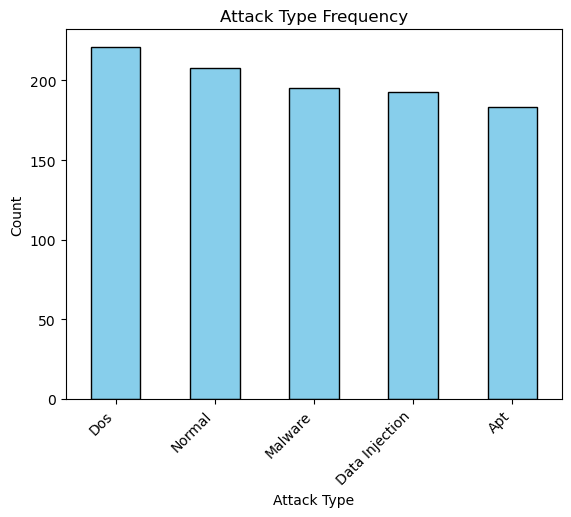

In [8]:
attack_counts = df['attack_type'].value_counts().sort_values(ascending=False)
attack_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Attack Type Frequency')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

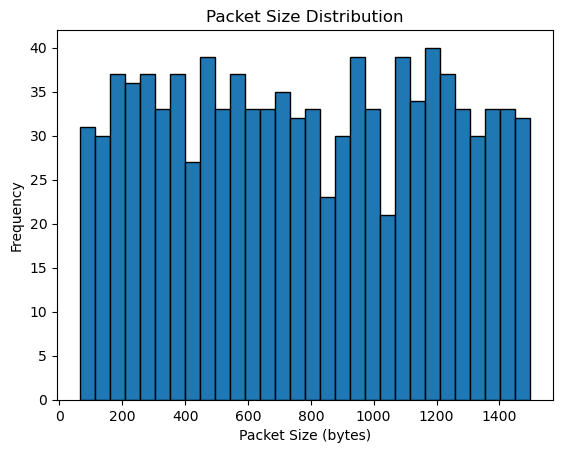

In [9]:
df['packet_size'].dropna().plot(kind='hist', bins=30, edgecolor='black')
plt.title('Packet Size Distribution')
plt.xlabel('Packet Size (bytes)')
plt.ylabel('Frequency')
plt.show()

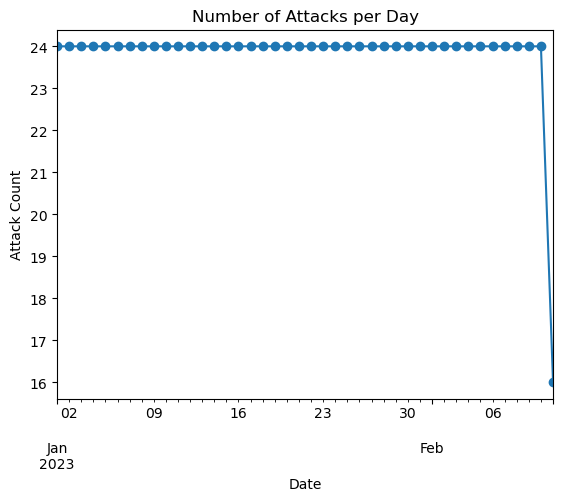

In [10]:
df.set_index('timestamp').resample('D')['attack_type'].count().plot(kind='line', marker='o')
plt.title('Number of Attacks per Day')
plt.xlabel('Date')
plt.ylabel('Attack Count')
plt.show()

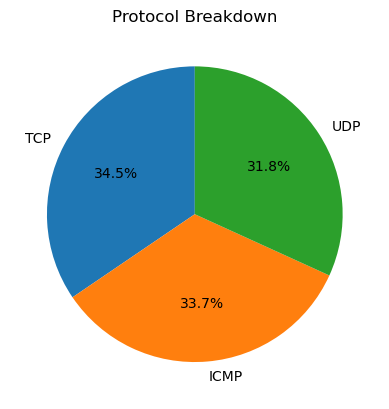

In [11]:
df['protocol'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Protocol Breakdown')
plt.ylabel('')
plt.show()

In [12]:
df.to_csv('cyber_threats_cleaned.csv', index=False)
print(f'✅ Saved cleaned dataset ({len(df)} rows) to cyber_threats_cleaned.csv')

✅ Saved cleaned dataset (1000 rows) to cyber_threats_cleaned.csv


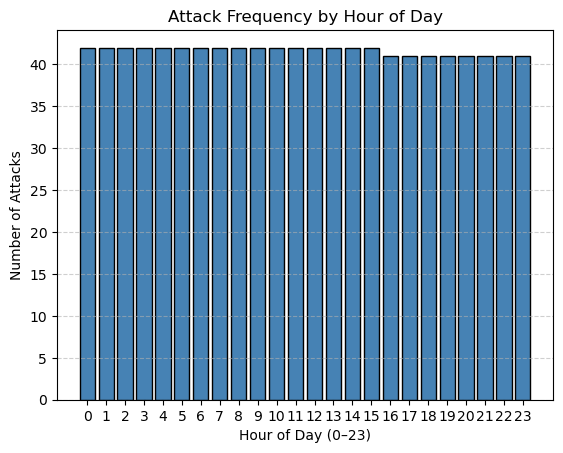

    hour  attack_type
0      0           42
1      1           42
2      2           42
3      3           42
4      4           42
5      5           42
6      6           42
7      7           42
8      8           42
9      9           42
10    10           42
11    11           42
12    12           42
13    13           42
14    14           42
15    15           42
16    16           41
17    17           41
18    18           41
19    19           41
20    20           41
21    21           41
22    22           41
23    23           41


In [13]:
# --- Attack frequency by hour ---
hourly_attacks = df.groupby("hour")["attack_type"].count().reset_index()

plt.bar(hourly_attacks["hour"], hourly_attacks["attack_type"], color="steelblue", edgecolor="black")
plt.title("Attack Frequency by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Attacks")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

print(hourly_attacks)

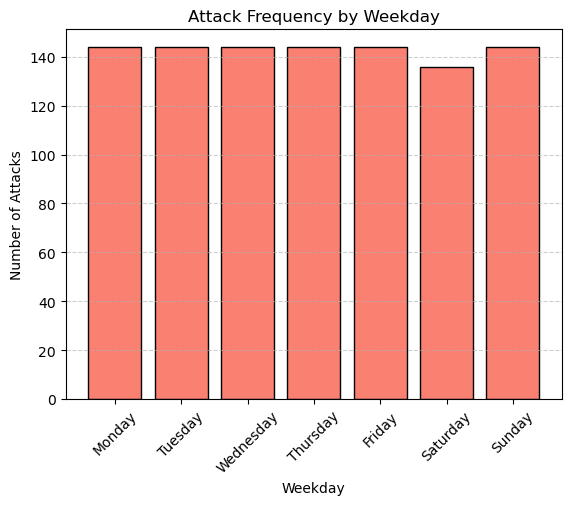

     weekday  attack_type
0     Monday          144
1    Tuesday          144
2  Wednesday          144
3   Thursday          144
4     Friday          144
5   Saturday          136
6     Sunday          144


In [14]:
# --- Attack frequency by weekday ---
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_attacks = (
    df.groupby("weekday")["attack_type"]
    .count()
    .reindex(weekday_order)
    .reset_index()
)

plt.bar(weekday_attacks["weekday"], weekday_attacks["attack_type"], color="salmon", edgecolor="black")
plt.title("Attack Frequency by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

print(weekday_attacks)


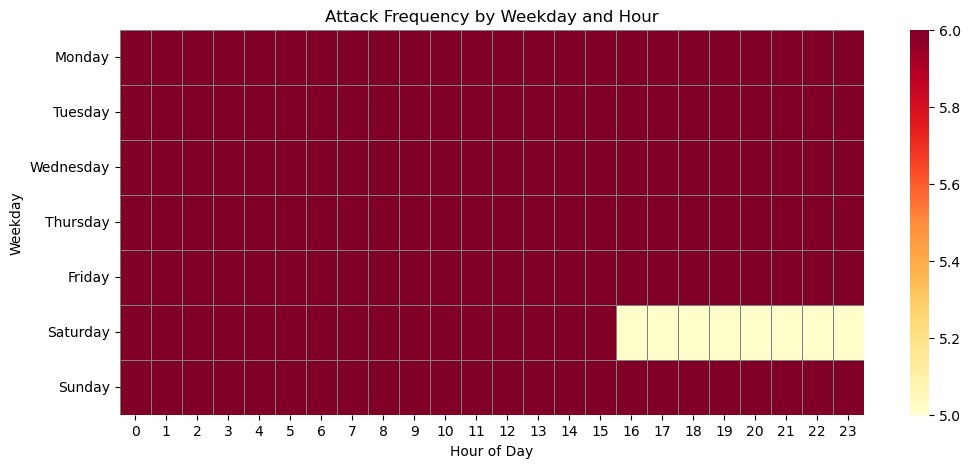

In [15]:
import seaborn as sns

# Pivot for heatmap
heatmap_data = df.pivot_table(
    index="weekday", columns="hour", values="attack_type", aggfunc="count"
).reindex(index=weekday_order)

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.5, linecolor="gray")
plt.title("Attack Frequency by Weekday and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.show()

In [23]:
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [24]:
# --- Chi-square test: Attack type vs Weekday ---

# Create a contingency table
contingency = pd.crosstab(df['weekday'], df['attack_type'])

chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)

if p < 0.05:
    print("✅ Significant: Attack occurrence depends on the weekday (p < 0.05)")
else:
    print("❌ Not significant: No strong evidence that weekday affects attack occurrence")

Chi-square statistic: 27.06932978959445
Degrees of freedom: 24
p-value: 0.3012318557109185
❌ Not significant: No strong evidence that weekday affects attack occurrence


In [25]:
from scipy.stats import f_oneway

# Step 1: Count attacks per hour per day (so we have numeric frequencies)
df['date'] = df['timestamp'].dt.date
hourly_counts = df.groupby(['date', 'hour'])['attack_type'].count().reset_index()

# Step 2: Create a list of attack count arrays for each hour
groups = [hourly_counts.loc[hourly_counts['hour'] == h, 'attack_type'].values
          for h in sorted(hourly_counts['hour'].unique())]

# Step 3: Perform ANOVA
f_stat, p_val = f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("✅ Significant: Attack frequency varies by hour (p < 0.05)")
else:
    print("❌ Not significant: No strong hourly pattern detected")

F-statistic: nan
p-value: nan
❌ Not significant: No strong hourly pattern detected


C:\Users\pnyamoha\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [26]:
from scipy.stats import kruskal

groups = [df[df["hour"] == h]["packet_size"].dropna() for h in sorted(df["hour"].unique())]
stat, p_val = kruskal(*groups)

print("Kruskal–Wallis H-statistic:", stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("✅ Significant differences between hours")
else:
    print("❌ No significant difference between hours")

Kruskal–Wallis H-statistic: 14.785710510498637
p-value: 0.9021489805771011
❌ No significant difference between hours


       Feature  Importance
0         hour    0.695966
2          day    0.133885
1  weekday_enc    0.102813
4   weekofyear    0.056737
3        month    0.010598


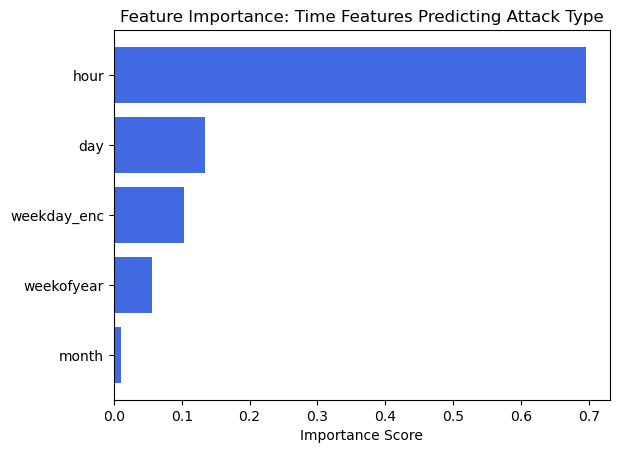

In [27]:
# --- Step 1: Extract time features ---
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekofyear'] = df['timestamp'].dt.isocalendar().week.astype(int)

# --- Step 2: Encode categorical features ---
# Convert weekday (Mon–Sun) and attack_type (target) to numeric codes
le_weekday = LabelEncoder()
df['weekday_enc'] = le_weekday.fit_transform(df['weekday'])

le_attack = LabelEncoder()
df['attack_label'] = le_attack.fit_transform(df['attack_type'])

# --- Step 3: Select features and target ---
X = df[['hour', 'weekday_enc', 'day', 'month', 'weekofyear']]
y = df['attack_label']

# --- Step 4: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --- Step 5: Train Random Forest ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# --- Step 6: Evaluate feature importance ---
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False)

# --- Step 7: Display results ---
print(importance_df)

# Plot
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.title('Feature Importance: Time Features Predicting Attack Type')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

📊 Ranked Temporal Feature Importance:
       Feature  Importance
0         hour    0.729404
1          day    0.113659
2  weekday_enc    0.076264
3   weekofyear    0.056385
4   is_weekend    0.012660
5        month    0.011629


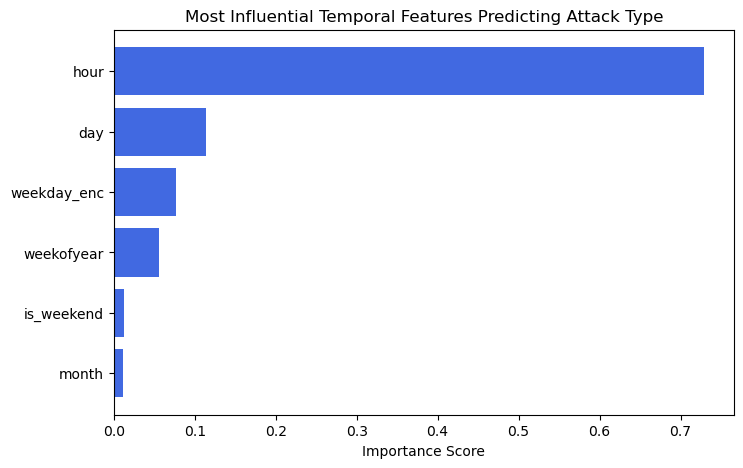

In [28]:
# --- Step 1: Extract temporal features ---
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekofyear'] = df['timestamp'].dt.isocalendar().week.astype(int)
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# --- Step 2: Encode categorical features ---
le_weekday = LabelEncoder()
df['weekday_enc'] = le_weekday.fit_transform(df['weekday'])

le_attack = LabelEncoder()
df['attack_label'] = le_attack.fit_transform(df['attack_type'])

# --- Step 3: Define features and target ---
X = df[['hour', 'weekday_enc', 'day', 'month', 'weekofyear', 'is_weekend']]
y = df['attack_label']

# --- Step 4: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Step 5: Train Random Forest classifier ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# --- Step 6: Compute feature importance ---
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# --- Step 7: Output ranked list ---
print("📊 Ranked Temporal Feature Importance:")
print(importance_df)

# --- Step 8: Plot ---
plt.figure(figsize=(8,5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.title('Most Influential Temporal Features Predicting Attack Type')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()